# TME 02 - Estimation de densité

DAC, Sorbonne Universite  
PIGEON Nolwen  
SADYKOVA Karima  

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score

In [6]:
POI_FILENAME = "../data/poi-paris.pkl"
parismap = mpimg.imread('../data/paris-48.806-2.23--48.916-2.48.jpg')
# coordonnees GPS de la carte
xmin, xmax = 2.23, 2.48  # coord_x min et max
ymin, ymax = 48.806, 48.916  # coord_y min et max
coords = [xmin, xmax, ymin, ymax]

In [7]:
def get_density2D(f, data, steps=100):
    """ Calcule la densité en chaque case d'une grille steps x steps dont les bornes sont calculées à partir du min/max de data. Renvoie la grille estimée et la discrétisation sur chaque axe.
    """
    xmin, xmax = data[:, 0].min(), data[:, 0].max()
    ymin, ymax = data[:, 1].min(), data[:, 1].max()
    xlin, ylin = np.linspace(xmin, xmax, steps), np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(xlin, ylin)
    grid = np.c_[xx.ravel(), yy.ravel()]
    res = f.predict(grid).reshape(steps, steps)
    return res, xlin, ylin


def show_density(f, data, steps=100, log=False):
    """
    Dessine la densité f et ses courbes de niveau sur une grille 2D calculée à partir de data, avec un pas de discrétisation de steps. Le paramètre log permet d'afficher la log densité plutôt que la densité brute
    """
    res, xlin, ylin = get_density2D(f, data, steps)
    xx, yy = np.meshgrid(xlin, ylin)
    plt.figure()
    show_img()
    if log:
        res = np.log(res+1e-10)
    plt.scatter(data[:, 0], data[:, 1], alpha=0.8, s=3)
    show_img(res)
    plt.colorbar()
    plt.contour(xx, yy, res, 20)


def show_img(img=parismap):
    """ Affiche une matrice ou une image selon les coordonnées de la carte de Paris.
    """
    origin = "lower" if len(img.shape) == 2 else "upper"
    alpha = 0.3 if len(img.shape) == 2 else 1.
    plt.imshow(img, extent=coords, aspect=1.5, origin=origin, alpha=alpha)
    # extent pour controler l'echelle du plan


def load_poi(typepoi, fn=POI_FILENAME):
    """ Dictionaire POI, clé : type de POI, valeur : dictionnaire des POIs de ce type : (id_POI, [coordonnées, note, nom, type, prix])

    Liste des POIs : furniture_store, laundry, bakery, cafe, home_goods_store, 
    clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
    """
    poidata = pickle.load(open(fn, "rb"))
    data = np.array([[v[1][0][1], v[1][0][0]]
                    for v in sorted(poidata[typepoi].items())])
    note = np.array([v[1][1] for v in sorted(poidata[typepoi].items())])
    return data, note

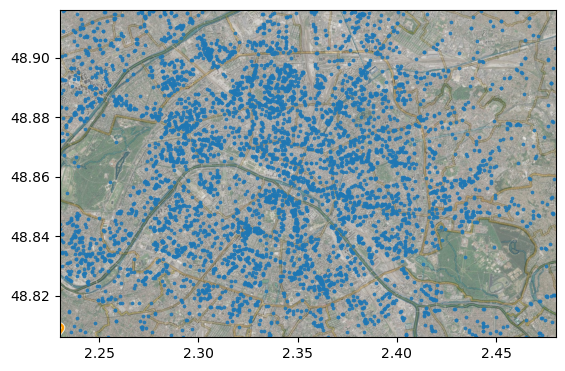

In [11]:
plt.ion()
# Liste des POIs : furniture_store, laundry, bakery, cafe, home_goods_store, clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
# La fonction charge la localisation des POIs dans geo_mat et leur note.
geo_mat, notes = load_poi("bar")

# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_mat[:, 0], geo_mat[:, 1], alpha=0.8, s=3)

In [35]:
class Density(BaseEstimator):
    def __init__(self) -> None:
        super().__init__()
    
    def fit(self, data):
        pass

    def predict(self, data):
        pass

    def score(self, data):
        density = self.predict(data)
        return np.log( np.where(density == 0, 1e-10, density) ).sum()

In [13]:
class Histogramme(Density):
	def __init__(self, steps=10):
		Density.__init__(self)
		self.steps = steps
		self.density = None
		self.bins = None

	def fit(self, x):
		# Apprend l'histogramme de la densité sur x
		self.density, self.bins = np.histogramdd(
			x, bins=self.steps, density=True)

	def predict(self, x):
		def to_bin(x):
			bins = np.array(self.bins)
			# Exception pour les points représentant les bornes de l'Histogramme, 
			# On les augmente un peu pour faire les faire rentrer
			# Evite un test dans la boucle 
			bins[-1] += 1e-10
			
			l = []
			xi_dim = x.shape[-1]
			for xi in x:
				tmp = []
				for i in range(xi_dim):
					bin_i = bins[i]
					xi_i = xi[i]
					if xi_i < bin_i[0] or xi_i > bin_i[-1]:
						tmp.append(None)
					else:
						bin_index = np.searchsorted(bin_i, xi_i) - 1
						tmp.append(bin_index)
				l.append(tuple(tmp))
			return l

		prediction = np.zeros(len(x), dtype=np.float32)
		for i, cords in enumerate(to_bin(x)):
			if None not in cords:
				prediction[i] = self.density[cords]
		return prediction

### Methode par Histogramme


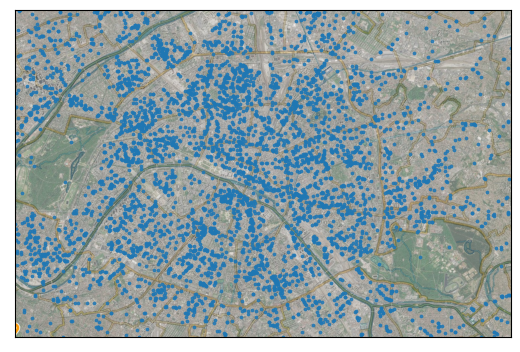

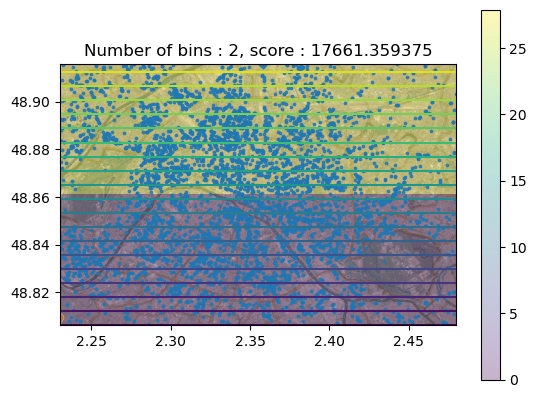

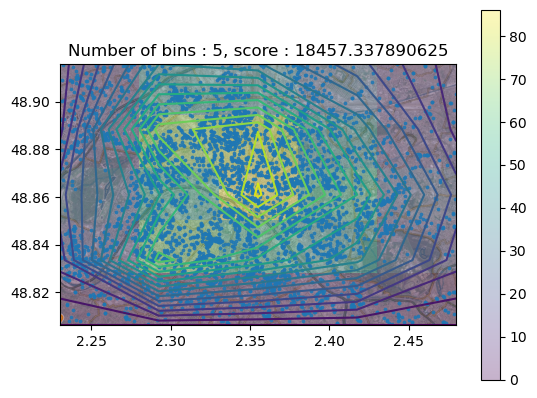

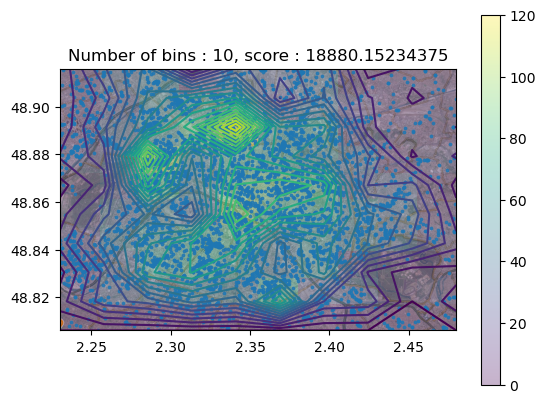

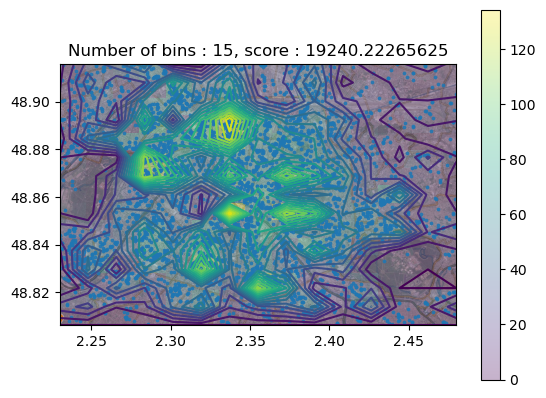

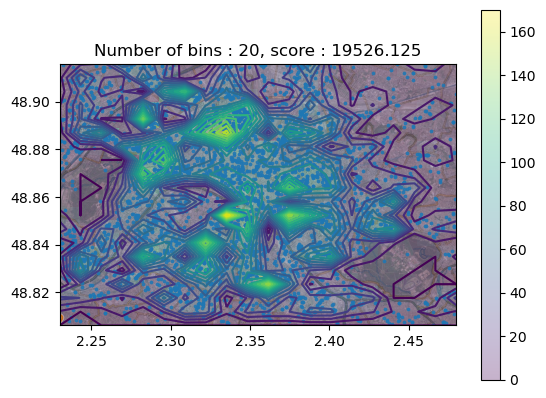

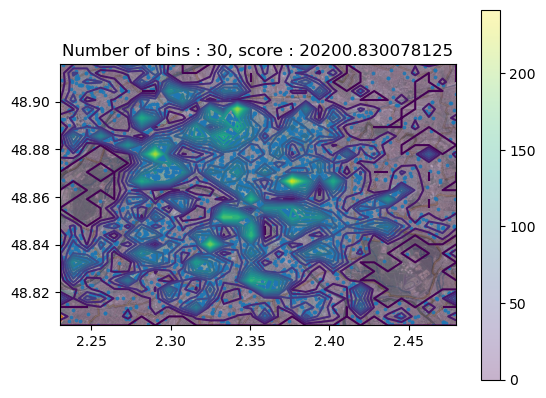

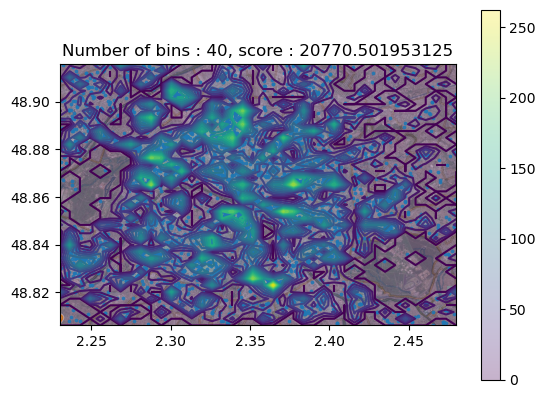

In [14]:
geo_mat, notes = load_poi("bar")

# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)
plt.xticks([])
plt.yticks([])

for steps in [2, 5, 10, 15, 20, 30, 40]:
	nc_hist = Histogramme(steps)
	nc_hist.fit(geo_mat)
	nc_hist.predict(geo_mat)
	show_density(nc_hist, geo_mat, steps)
	plt.gca().set_title(f'Number of bins : {steps}, score : {nc_hist.score(geo_mat)}')

### Validation croisé


### Restos


Meilleurs steps : 17


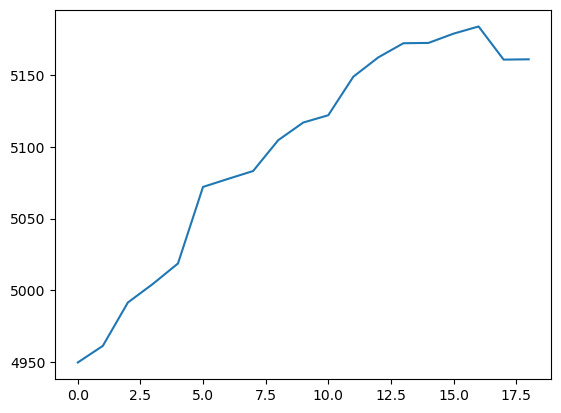

In [15]:
mean_list = []
steps_list = []
for steps in range(1, 20):
	geo_mat, notes = load_poi("restaurant")
	score_list = cross_val_score(Histogramme(steps=steps), geo_mat)
	mean_list.append(np.mean(score_list))
	steps_list.append(steps)
print("Meilleurs steps :", steps_list[np.argmax(mean_list)])
plt.plot(mean_list)

### Nightclub


Meilleurs steps : 5


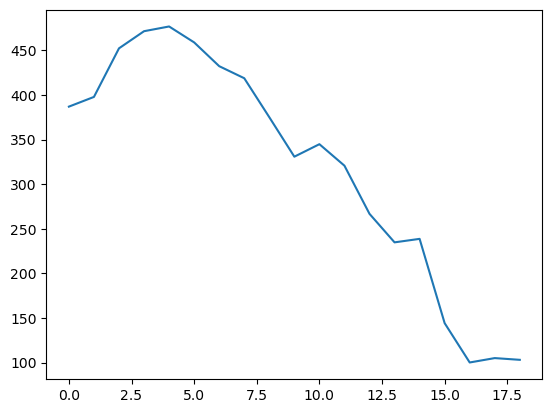

In [16]:
mean_list = []
steps_list = []
for steps in range(1, 20):
	geo_mat, notes = load_poi("night_club")
	score_list = cross_val_score(Histogramme(steps=steps), geo_mat)
	mean_list.append(np.mean(score_list))
	steps_list.append(steps)
print("Meilleurs steps :", steps_list[np.argmax(mean_list)])
plt.plot(mean_list)

## Méthodes à noyaux


In [18]:
def kernel_uniform(x):
	return np.where((np.abs(x) < 0.5).all(axis=1), 1, 0)

def kernel_gaussian(x):
    d = x.shape[-1]
    return np.exp(-0.5 * np.linalg.norm(x, axis=1)**2) * (2*np.pi)**(-d/2) 

In [24]:
class KernelDensity(Density):
	def __init__(self, kernel=None, sigma=0.1):
		Density.__init__(self)
		self.kernel = kernel
		self.sigma = sigma

	def fit(self, x):
		self.x = x

	def predict(self, data):
		# retourne la densité associée à chaque point de data
		n, d = self.x.shape
		l = []
		for x_i in data:
			x_i_stacked = np.vstack([x_i]*n)
			sum_value = self.kernel((x_i_stacked - self.x)/self.sigma).sum()
			l.append(sum_value / (n*self.sigma**d))
		return np.array(l)

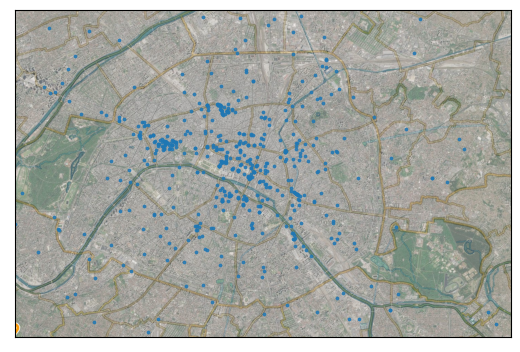

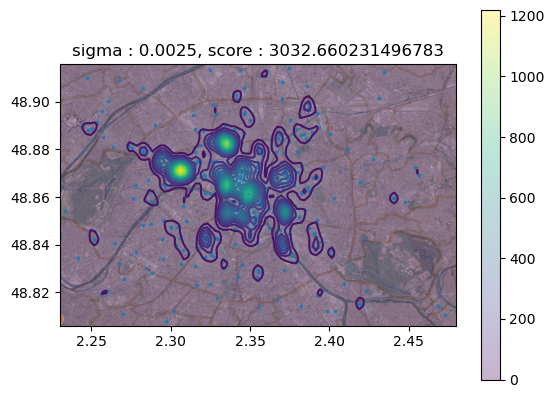

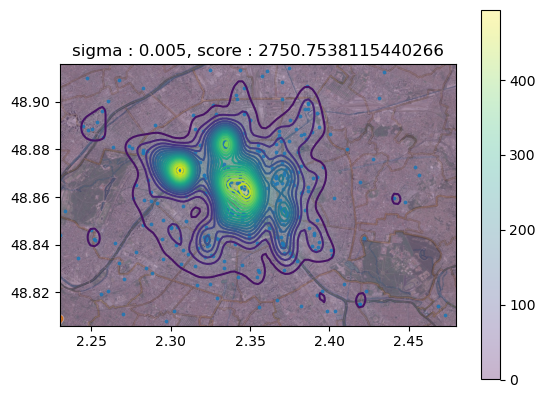

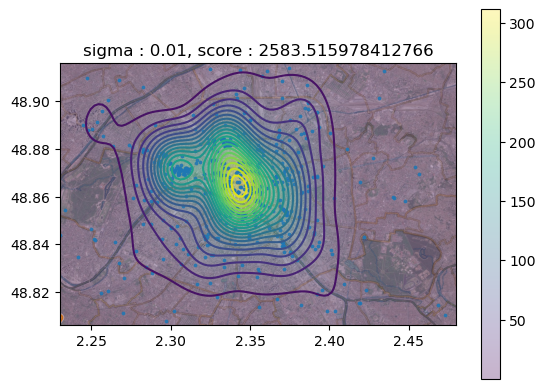

In [25]:
geo_mat, notes = load_poi("night_club")

# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)
plt.xticks([])
plt.yticks([])

for sigma in [0.0025, 0.005, 0.01]:
    nc_kernelDensity = KernelDensity(kernel=kernel_gaussian, sigma=sigma)
    nc_kernelDensity.fit(geo_mat)
    show_density(nc_kernelDensity, geo_mat)
    plt.gca().set_title(f'sigma : {sigma}, score : {nc_kernelDensity.score(geo_mat)}')

## Nadaraya-Watson


In [42]:
class Nadaraya(Density):
    def __init__(self, kernel, sigma=0.01) -> None:
        super().__init__()
        self.kernel = kernel
        self.sigma = sigma
    
    def fit(self, x, y):
        self.x = x
        self.y = y

    def predict(self, data):
        prediction = []
        for x in data:
            noyau = self.kernel((x - self.x) / self.sigma) + 1e-10
            prediction.append(np.sum(self.y * noyau) / np.sum(noyau))
        return np.array(prediction)

/var/folders/zf/0x6tvbjd3j70jvsbzmg1jvn40000gn/T/ipykernel_33801/2780635586.py:13: RuntimeWarning: invalid value encountered in log
  return np.log( np.where(density == 0, 1e-10, density) ).sum()


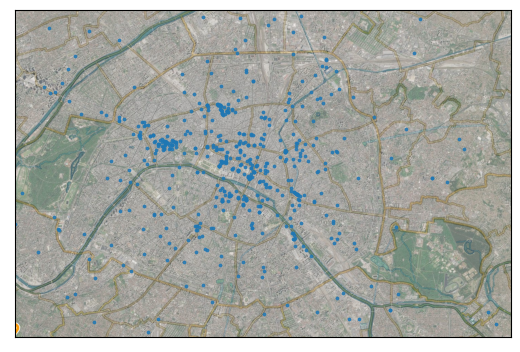

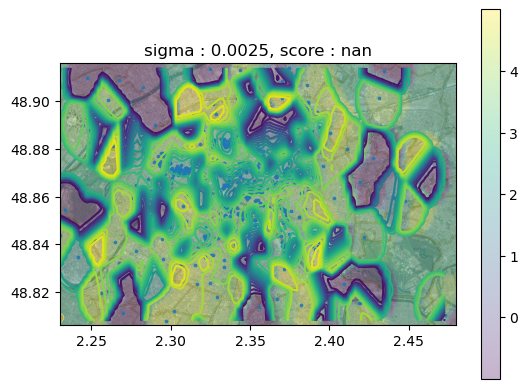

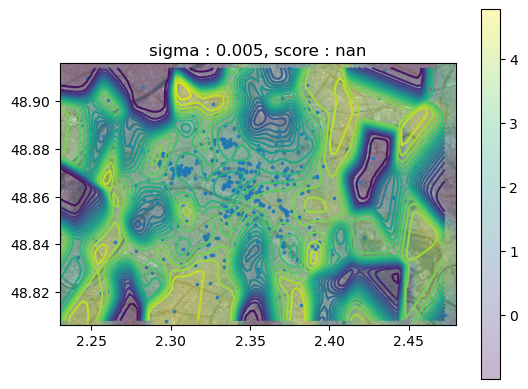

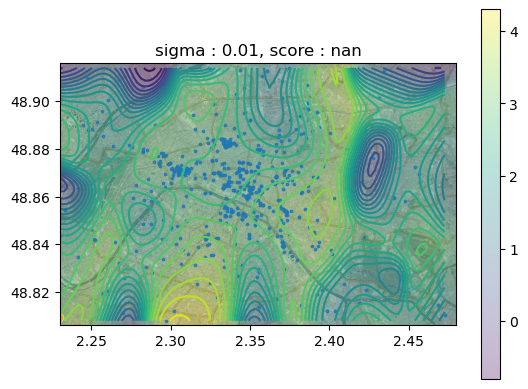

In [34]:
geo_mat, notes = load_poi("night_club")

# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)
plt.xticks([])
plt.yticks([])

for sigma in [0.0025, 0.005, 0.01]:
    nc_NadarayaDensity = Nadaraya(kernel=kernel_gaussian, sigma=sigma)
    nc_NadarayaDensity.fit(geo_mat, notes)
    show_density(nc_NadarayaDensity, geo_mat)
    plt.gca().set_title(f'sigma : {sigma}, score : {nc_NadarayaDensity.score(geo_mat)}')

In [36]:
def mse(y, y_pred):
    return ((y-y_pred)**2).mean()

In [39]:
from sklearn.model_selection import train_test_split

X, y = load_poi("bar")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

print(X.shape, y.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4888, 2) (4888,)
(3910, 2) (978, 2) (3910,) (978,)


In [43]:
nw = Nadaraya(kernel_uniform)
nw.fit(X_train, y_train)
y_pred = nw.predict(X_test)
y_pred_nan = np.nan_to_num(y_pred, nan=0)
mse(y_test, y_pred_nan)

3.5716268864331906

In [44]:
nw = Nadaraya(kernel_uniform)
nw.fit(X_train, y_train)
y_pred = nw.predict(X_test)
y_pred_nan = np.nan_to_num(y_pred, nan=0)
mse(y_test, y_pred_nan)

3.5716268864331906

In [46]:
sigmas = [0.01, 0.1, 1, 10, 100]
mses = []

for sigma in sigmas:
    nw = Nadaraya(kernel_gaussian, sigma)
    nw.fit(X_train, y_train)
    y_pred = nw.predict(X_test)
    y_pred_nan = np.nan_to_num(y_pred, nan=0)
    m = mse(y_test, y_pred_nan)
    mses.append(m)
    
mses

[3.3586627182838344,
 3.5388546992219254,
 3.5578004290514307,
 3.5579902487399253,
 3.557992147073826]